### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = subjects.nsd.ripple_sess + subjects.sd.ripple_sess

### Plot ripples histogram for a single session

In [ ]:
from neuropy.plotting import plot_epochs
from scipy.stats import binned_statistic

sessions = subjects.sd.ratUday1

fig = Fig(grid=(2, 2))
for sub, sess in enumerate(sessions):
    ax = plt.subplot(fig.gs[sub])
    starts = sess.ripple.starts
    durations = sess.ripple.durations
    bins = np.arange(0, sess.eegfile.duration, 600)
    # hist_rpl = np.histogram(starts,bins=bins)[0]
    hist_rpl = binned_statistic(starts, durations, bins=bins, statistic="sum")[0]
    plot_epochs(ax, sess.paradigm)
    ax.plot(bins[:-1] + 300, hist_rpl / 600, "k")
    ax.set_xlabel("Time")
    ax.set_ylabel("Ripple rate")
    print(sess.ripple.metadata)


### Ripple rate first hour **between** SD and NSD (or only restrict to 1h NREM sleep of NSD)
- One possiblity of faster decay of replay during sleep deprivation could be reduced ripple rate at the begining of POST. This may suggest that in order for cells to replay they need sufficient number/amount of exicitation to last for certain duration of time, so a lower ripple rate could interrupt this requirement.

In [ ]:
rpl_rate = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    w = 2 * 3600 # window size
    rpl_rate_sub = sess.ripple_nomerge.time_slice(post[0], post[0] + w).n_epochs / w
    rpl_rate.append(
        pd.DataFrame({"sub": sess.sub_name, "rpl_rate": [rpl_rate_sub], "grp": sess.tag})
    )

rpl_rate = pd.concat(rpl_rate,ignore_index=True)


In [ ]:

_,ax = plt.subplots()
import seaborn as sns

sns.lineplot(data=rpl_rate,x='grp',y='rpl_rate',hue='sub',marker='o')

### Ripple rate first 5 hour **within** SD and NSD across Zt times


In [28]:
sessions = subjects.nsd.ripple_sess + subjects.sd.ripple_sess
ripple_rate_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    zt_start = np.array([0, 2.5, 5])
    zt_stop = np.array([2.5, 5, 7.5])
    n_epochs = len(zt_start)
    durations = (zt_stop - zt_start) * 3600

    bins = np.vstack((zt_start, zt_stop)).T.flatten() * 3600 + post[0]
    rpls = sess.ripple.starts

    binsz = np.diff(bins).mean()
    hist_rpl = np.histogram(rpls, bins=bins)[0][::2]

    ripple_rate_df.append(
        pd.DataFrame(
            {
                "rate": hist_rpl / durations,
                "Zt": [f"{zt_start[_]}-{zt_stop[_]}" for _ in range(n_epochs)],
                "sub": sub,
                "grp": sess.tag,
            }
        ),
    )

ripple_rate_df = pd.concat(ripple_rate_df, ignore_index=True)
subjects.GroupData().save(ripple_rate_df,'ripple_rate')


ripple_rate saved


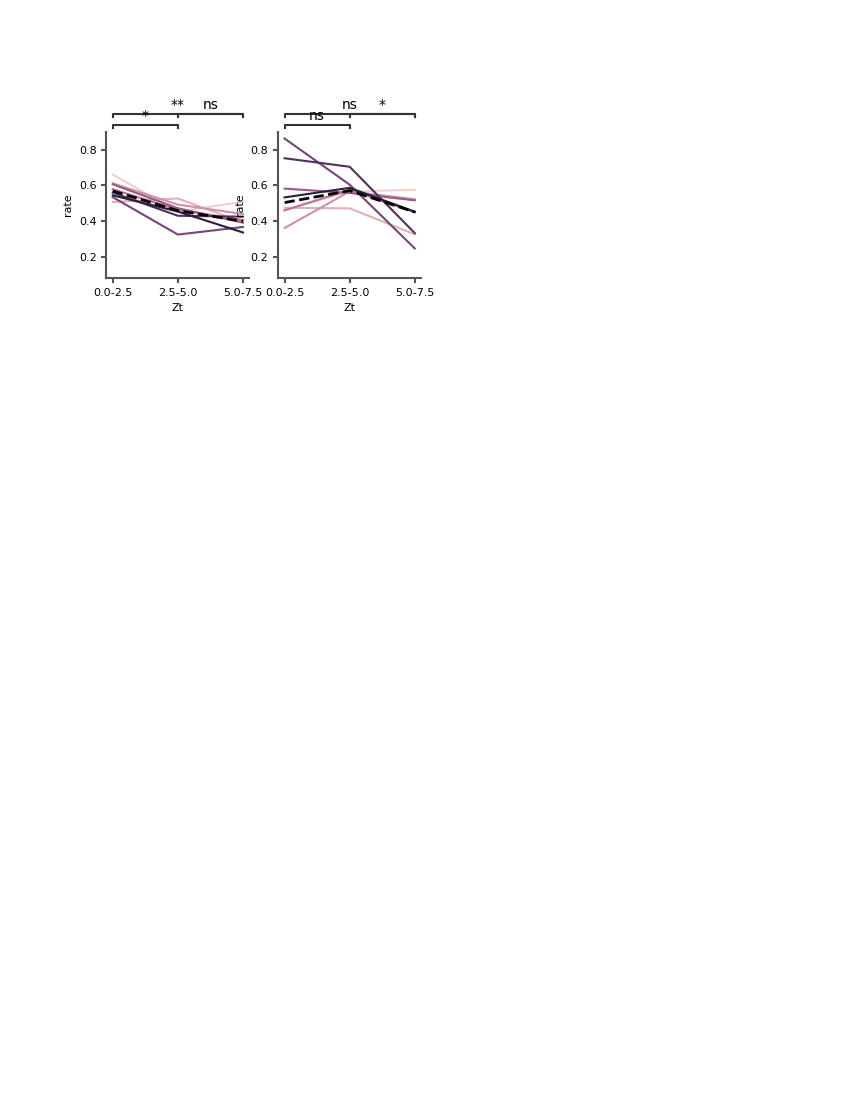

In [29]:
import seaborn as sns
from neuropy.plotting import Fig
from statannotations.Annotator import Annotator

fig = Fig(grid=(5, 4),constrained_layout=False)

for i, grp in enumerate(["NSD",'SD']):
    df = ripple_rate_df[ripple_rate_df["grp"] == grp]
    ax = fig.subplot(fig.gs[i])
    sns.lineplot(
        data=df,
        x="Zt",
        y="rate",
        ax=ax,
        hue="sub",
        legend=False,
        # palette=["#BDBDBD"],
        # ls="--",
    )
    sns.lineplot(
        data=df,
        x="Zt",
        y="rate",
        estimator=np.median,
        ax=ax,
        legend=False,
        color='k',
        ls="--",
        ci=None,
        lw=2,
    )
    # ax.set_yscale('log')
    ax.set_ylim([0.08, 0.9])
    # ax.set_xticks(np.arange(1, 10, 2))
    orders = df.Zt.unique()
    pairs = [(orders[t1], orders[t2]) for t1,t2 in zip([0,1,2],[1,2,0])]

    annotator = Annotator(
        ax,
        pairs,
        data=df,
        x="Zt",
        y="rate",
        order=orders,
        # hue="grp",
        # hue_order=group,
    )
    annotator.configure(
        test="Wilcoxon", text_format="star", loc="outside", verbose=False
    )

    annotator.apply_and_annotate()



# figure.savefig(subjects.figpath_sd/'ripple_rate')

### Inter-ripple duration (Ripple ISI)


In [2]:
dur_df = pd.DataFrame()
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    zts =np.array([0,4,5]) # np.arange(0, 9, 4)
    t_starts = zts * 3600 + post[0]

    acg_zt = []
    firing_neurons = []
    for i, t in enumerate(t_starts):
        starts = sess.ripple.time_slice(t, t + 3600).starts
        dur_df = dur_df.append(
            pd.DataFrame(
                {"isi": np.diff(starts), "Zt": f"Zt{zts[i]+1}", "grp": sess.tag}
            ),
            ignore_index=True,
        )


/tmp/ipykernel_3535346/1044031516.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dur_df = dur_df.append(
/tmp/ipykernel_3535346/1044031516.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dur_df = dur_df.append(
/tmp/ipykernel_3535346/1044031516.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dur_df = dur_df.append(
/tmp/ipykernel_3535346/1044031516.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dur_df = dur_df.append(
/tmp/ipykernel_3535346/1044031516.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dur_df = dur_df.append(


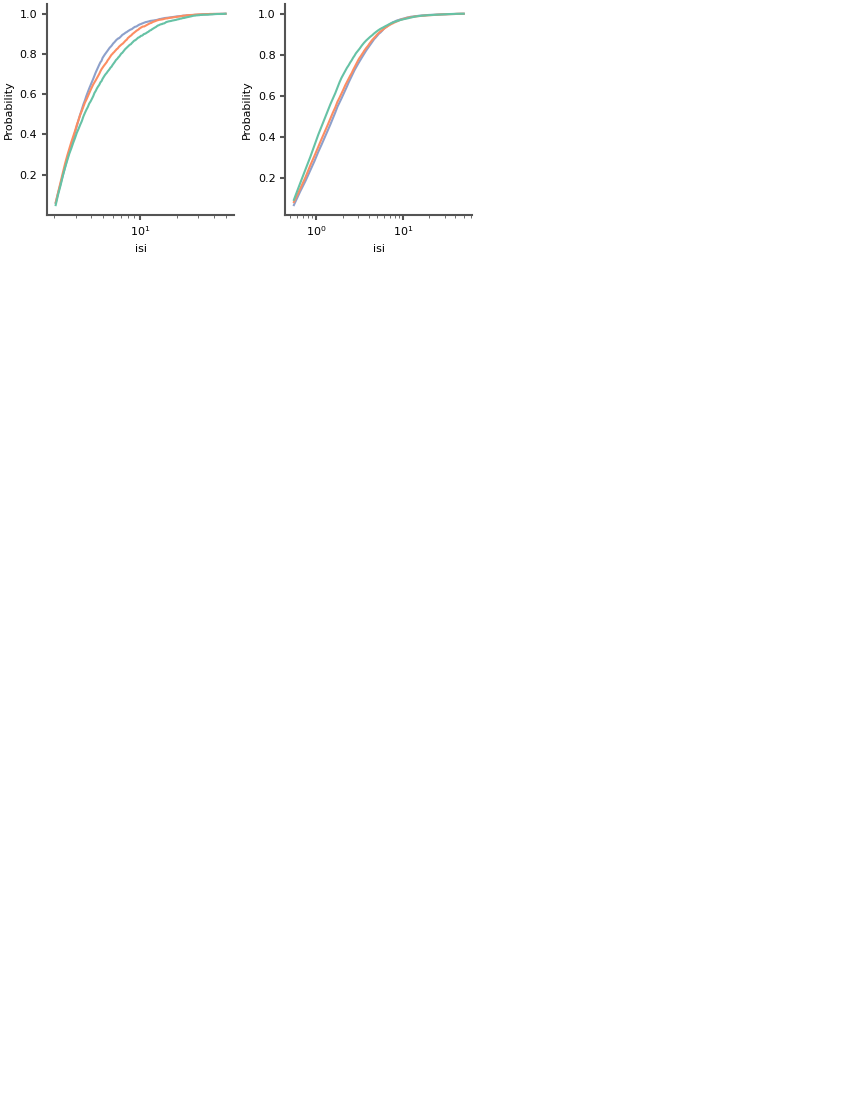

In [7]:
import seaborn as sns
from neuropy import plotting

fig = plotting.Fig(grid=(5, 4))
bins = [np.arange(2, 50, 0.1), np.arange(0.5, 50, 0.1)]
for i, g in enumerate(["SD", "NSD"]):
    df = dur_df[dur_df["grp"] == g]
    ax = plt.subplot(fig.gs[i])
    sns.histplot(
        data=df,
        x="isi",
        hue="Zt",
        ax=ax,
        stat="probability",
        bins=bins[i],
        element="poly",
        common_bins=True,
        common_norm=False,
        fill=False,
        legend=None,
        cumulative=True,
        palette="Set2",
    )
    ax.set_xscale("log")
    # ax.set_yscale('log')
    # ax.grid()


### Total/mean ripple duration from first hour to last hour SD

In [25]:
print(f"#Sessions {len(sessions)}")
rpl_duration = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    # period = np.arange(9) * 3600 + post[0]
    zts = np.array([0, 2.5, 5])
    period = zts * 3600 + post[0]

    for i, t in enumerate(period):

        rpl_duration.append(
            pd.DataFrame(
                {
                    "Zt": f"{zts[i]}-{zts[i]+2.5}",
                    "rpl_duration": [
                        sess.ripple.time_slice(t, t + 2.5 * 3600).durations.sum()
                    ],
                    "grp": sess.tag,
                    "sub": sub,
                }
            ),
        )

rpl_duration = pd.concat(rpl_duration, ignore_index=True)

subjects.GroupData().save(rpl_duration, "ripple_total_duration")


#Sessions 16
ripple_total_duration saved


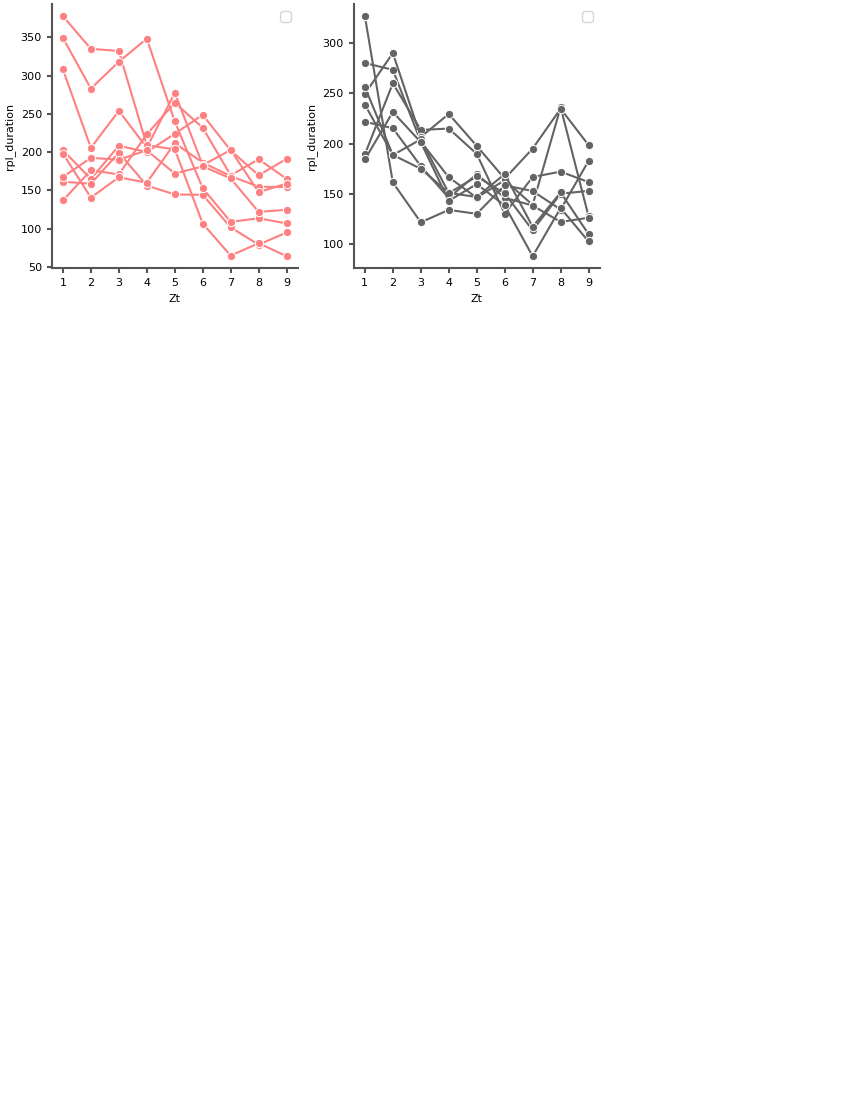

In [3]:
import seaborn as sns
from neuropy import plotting

fig = plotting.Fig(grid=(4,3))

colors =[subjects.sd.color(1.5),subjects.nsd.color(1.5)]
n_subs=[8,8]
for i, grp in enumerate(["SD", "NSD"]):
    data = rpl_duration[rpl_duration["grp"] == grp]
    ax = fig.subplot(fig.gs[i])
    sns.lineplot(
        data=data,
        x="Zt",
        y="rpl_duration",
        hue="sub",
        marker="o",
        palette=[colors[i]]* n_subs[i],
        ax=ax,
        legend=None,
        ci=None,
    )
    ax.legend('')
    # ax.set_xlim([-1,4])
    # ax.set_ylim([30,450])


# g=sns.relplot(
#     data=rpl_duration,
#     x="epoch",
#     y="rpl_duration",
#     hue="sub",
#     col="grp",
#     # row='rpl_duration',
#     kind="line",
#     marker="o",
#     palette=['gray']*len(sessions),
# )

# [ax.set_xlim([-1,2]) for ax in g.axes.reshape(-1)]
# figure.savefig(subjects.figpath_sd/'ripple_total_duration_zt1_vs_zt5')

### Ripple duration comparison between SD and NSD animals
- I compared the ripple duration distribution for Zt1 and Zt5 between NSD and SD sessions. Ripple durations were pooled across sessions. The distribution curves looked different in Zt1 (seems to be driven by outliers) but exactly the same during Zt5.

In [5]:
rpl_dur = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    t_starts = np.arange(5) * 3600 + post[0]
    # t = post[0]

    # --- for zt1 comparison ------
    # rpl_dur = rpl_dur.append(
    #     pd.DataFrame(
    #         {
    #             "durations": sess.ripple.time_slice(t, t +1* 3600).durations,
    #             "grp": sess.tag,
    #         }
    #     ),
    #     ignore_index=True,
    # )

    # --- for hourly comparison between SD and NSD -----
    rpl_dur.append(
        pd.concat(
            [
                pd.DataFrame(
                    {
                        "durations": sess.ripple.time_slice(t, t + 3600).durations,
                        "zt": ind + 1,
                        'animal': sub,
                        "grp": sess.tag,
                    }
                )
                for ind, t in enumerate(t_starts)
            ]
        ),
    )
rpl_dur = pd.concat(rpl_dur,ignore_index=True)

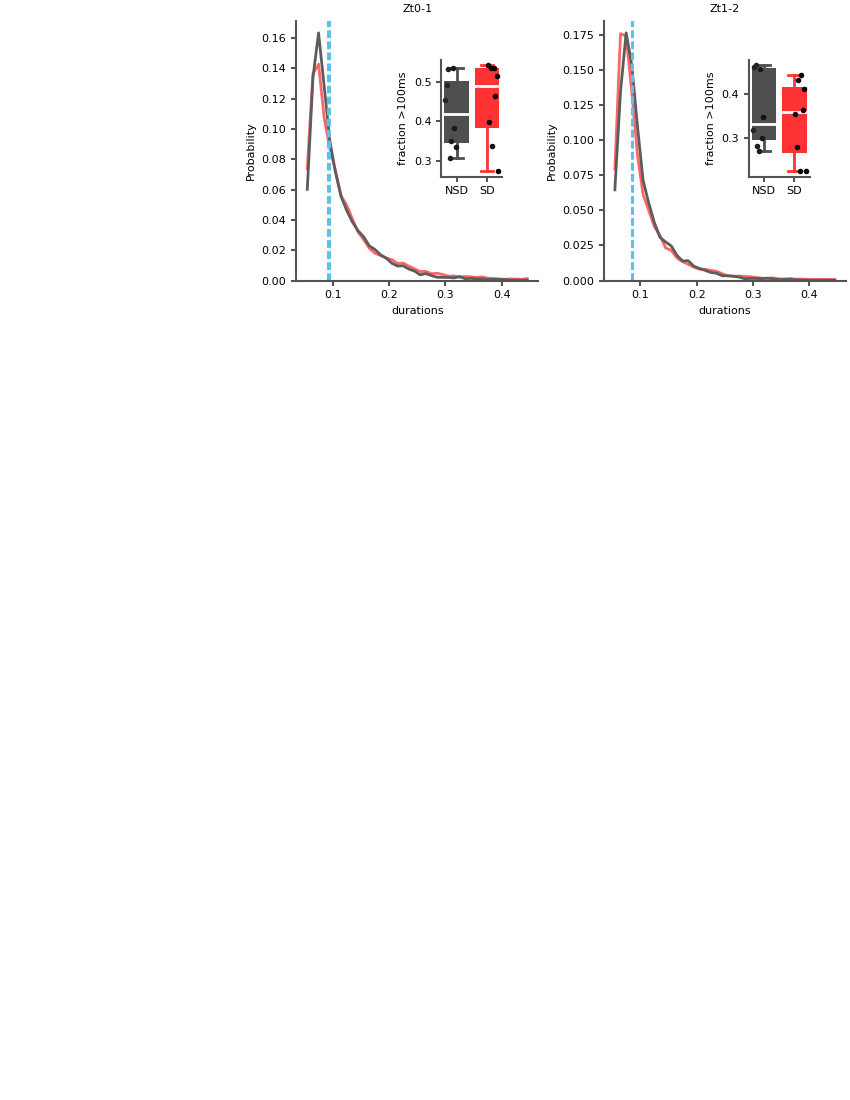

In [23]:
import seaborn as sns
from neuropy.plotting import Fig
import matplotlib as mpl
from neuropy.plotting.dataviz import boxplot

fig = Fig(grid=(4, 3))

for i, zt in enumerate([1, 5]):
    df = rpl_dur[rpl_dur["zt"] == zt]
    medians = df.groupby("grp").median().durations
    ax = plt.subplot(fig.gs[i + 1])
    ax = sns.histplot(
        data=df,
        x="durations",
        hue="grp",
        stat="probability",
        bins=np.arange(0.05, 0.455, 0.010),
        common_norm=False,
        # cumulative=True,
        element="poly",
        fill=False,
        ax=ax,
        # legend=None,
        palette=subjects.colors_sd(1.4),
        lw=2,
    )
    # ax.set_ylim([0, 0.14])
    ax.axvline(medians.NSD, ls="--")
    ax.axvline(medians.SD, ls="--")
    # ax.set_xscale('log')
    ax.legend("", frameon=False)
    ax.set_title(f'Zt{i}-{i+1}')

    n_rpls = df.groupby(["animal", "grp"]).count().reset_index()
    n_long_rpls = (
        df[df.durations > 0.1].groupby(["animal", "grp"]).count().reset_index()
    )
    n_rpls["long_ripples_frac"] = n_long_rpls.durations / n_rpls.durations

    ax2 = ax.inset_axes([0.6, 0.4, 0.25, 0.45])
    boxplot(
        data=n_rpls,
        x="grp",
        y="long_ripples_frac",
        ax=ax2,
        showfliers=False,
        palette=subjects.colors_sd(1.2),
    )
    sns.swarmplot(
        data=n_rpls,
        x="grp",
        y="long_ripples_frac",
        ax=ax2,
        hue='animal',
        dodge=True,
        color="k",
        size=4,
    )
    ax2.legend('',frameon=False)
    ax2.set_ylabel("fraction >100ms")
    ax2.set_xlabel("")
    # ax2.set_ylim([0.2, 0.9])
